In [ ]:
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    # 実行されないようにセルの内容を無視する
    print(f"Skipping cell:\n{cell}")

In [35]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib

from geolib import geohash

import geopandas as gpd
import matplotlib.pyplot as plt
#from shapely.geometry import Point
from shapely import Point,Polygon
import geopy
import geopy.distance
#import geohash2
from geodatasets import get_path,data
from ipywidgets import interact,Select,Dropdown
import folium
from folium.plugins import TimestampedGeoJson
import branca.colormap as cm

from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from tqdm import tqdm
from IPython.display import display

import sys
sys.path.append('../')

from utils import (Multiple_Charts,
                   ProcessData,
                   trans_chara,
                   fill_missing_values,
                   fill_missing_with_mode,
                   find_nearest_station_main_table,
                   calculate_distance,
                   convert_kanji_to_fullwidth_2,
                   encode_geohash,
                   to_cat_col,
                   TreeExecution,
                   VotingModel,
                   submisson_datetime,
                   check_dataframe_elements
                   )

try:
    # 通常のスクリプト環境
    script_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # Jupyter NotebookやIPython環境
    script_dir = os.getcwd()
print(script_dir)

# ベースフォルダのパスを作成
base_dir = os.path.abspath(os.path.join(script_dir, r"../.."))
print(base_dir)  # 実際のフルパスが表示されます

TOTAL_PRICE_LOG="取引価格（総額）_log"
PRICE_PER_AREA_LOG="単位面積あたりの取引価格_log"

PROJECT_DIRECYORY=base_dir

DATA_INTERMEDIATE_RESULTS_CHECKPOINTS=os.path.join(base_dir,"data/intermediate_results/checkpoints")

#TARGET="取引価格（総額）_log"

c:\Users\yuto2\projects\Nishika\apartment_price_prediction_summer_2024\code\EDA
c:\Users\yuto2\projects\Nishika\apartment_price_prediction_summer_2024


コンペデータ可視化(下処理なし)

In [36]:
files = glob.glob(os.path.join(base_dir, "data/competition_data/train/train/*.csv"))
    #r"C:\Users\yuto2\OneDrive\ドキュメント\Pythonフォルダ\Nishika\中古マンション価格予測_2024夏の部\ダウンロード_データ\train\train\*.csv")
data_list = []
for file in files:
    data_list.append(pd.read_csv(file, index_col=0))
df = pd.concat(data_list)
df_copy=df.copy()
print("trainの内容")
check_dataframe_elements(df)

df_test=pd.read_csv(os.path.join(base_dir,"data/competition_data/test.csv"),index_col=0)
df_test_copy=df_test.copy()
print("testの内容")
check_dataframe_elements(df_test)


# カラム 'A' の欠損値の数を確認
tre_missing_values_count = df['最寄駅：名称'].isnull().sum()
tes_missing_values_count = df_test['最寄駅：名称'].isnull().sum()
print(f"学習データの欠損値の数: {tre_missing_values_count}")
print(f"テストデータの欠損値の数: {tes_missing_values_count}")

C:\Users\yuto2\AppData\Local\Temp\ipykernel_47892\826571061.py:5: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_list.append(pd.read_csv(file, index_col=0))
C:\Users\yuto2\AppData\Local\Temp\ipykernel_47892\826571061.py:5: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_list.append(pd.read_csv(file, index_col=0))


trainの内容
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1009271 entries, 1046933 to 47011639
Data columns (total 28 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   種類            1009271 non-null  object 
 1   価格情報区分        1009271 non-null  object 
 2   地域            0 non-null        float64
 3   市区町村コード       1009271 non-null  int64  
 4   都道府県名         1009271 non-null  object 
 5   市区町村名         1009271 non-null  object 
 6   地区名           1008610 non-null  object 
 7   最寄駅：名称        998620 non-null   object 
 8   最寄駅：距離（分）     964322 non-null   object 
 9   間取り           976570 non-null   object 
 10  面積（㎡）         1009271 non-null  object 
 11  土地の形状         0 non-null        float64
 12  間口            0 non-null        float64
 13  延床面積（㎡）       0 non-null        float64
 14  建築年           979931 non-null   object 
 15  建物の構造         977046 non-null   object 
 16  用途            734705 non-null   object 
 17  今後の利用目的    

In [37]:
df=pd.read_csv(os.path.join(DATA_INTERMEDIATE_RESULTS_CHECKPOINTS,"preprocess_main_table.csv"),index_col=0)
df=df[['dataset', 'ID', '価格情報区分', '都道府県名', '市区町村名', '地区名', '住所不一致_Flag', '住所',
       '最寄駅：名称', '最寄駅：距離（分）', '徒歩時間_10分単位', 'x_api', 'y_api', 'lon', 'lat',
       '間取り', '面積（㎡）', '建築年', '建物の構造', '用途', '今後の利用目的', '都市計画', '建ぺい率（％）',
       '容積率（％）', '取引時点', '改装', '取引の事情等',"取引価格（総額）_log", '単位面積あたりの取引価格_log', '建築西暦年', '築年数',
       'log_面積（㎡）', '購入までの築年数', '面積（㎡）-最寄駅：距離（分）', '面積（㎡）-築年数',
       '面積（㎡）容積率（％）_combi', '旧耐震フラグ', '最寄駅までの距離', 'geohash_2', 'geohash_3',
       'geohash_4', 'geohash_5', 'geohash_6', 'geohash_7', '県_市_count',
       '建築年_count', '県_市_geohash_2_駅数', '県_市_geohash_3_駅数', '県_市_geohash_4_駅数',
       '県_市_geohash_5_駅数', '県_市_geohash_6_駅数', '県_市_geohash_7_駅数',
       '県_市_geohash_2_駅徒歩時間平均', '県_市_geohash_2_建築年平均', '県_市_geohash_3_駅徒歩時間平均',
       '県_市_geohash_3_建築年平均', '県_市_geohash_4_駅徒歩時間平均', '県_市_geohash_4_建築年平均',
       '県_市_geohash_5_駅徒歩時間平均', '県_市_geohash_5_建築年平均', '県_市_geohash_6_駅徒歩時間平均',
       '県_市_geohash_6_建築年平均', '県_市_geohash_7_駅徒歩時間平均', '県_市_geohash_7_建築年平均']]


In [38]:
check_dataframe_elements(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063673 entries, 0 to 1063672
Data columns (total 64 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   dataset                1063673 non-null  object 
 1   ID                     1063673 non-null  int64  
 2   価格情報区分                 1063673 non-null  object 
 3   都道府県名                  1063673 non-null  object 
 4   市区町村名                  1063673 non-null  object 
 5   地区名                    1063608 non-null  object 
 6   住所不一致_Flag             1063673 non-null  int64  
 7   住所                     1063673 non-null  object 
 8   最寄駅：名称                 1063616 non-null  object 
 9   最寄駅：距離（分）              1014618 non-null  float64
 10  徒歩時間_10分単位             1014618 non-null  float64
 11  x_api                  1063616 non-null  float64
 12  y_api                  1063616 non-null  float64
 13  lon                    1051220 non-null  float64
 14  lat               

In [39]:
#train,testの結合データをdf_allとして保存
df_all=df.copy()

# データフレームを分割
df_train = df[df['dataset'] == 'train'].set_index('ID')
df_test = df[df['dataset'] == 'test'].set_index('ID')

# datasetカラムを削除
df_train = df_train.drop(columns=['dataset'])
df_test = df_test.drop(columns=['dataset'])

df_train,cat_cols=to_cat_col(df_train)

# インデックスを読み込み
train_index = np.load(os.path.join(DATA_INTERMEDIATE_RESULTS_CHECKPOINTS,"train_index_l1_cv.npy"))
test_index = np.load(os.path.join(DATA_INTERMEDIATE_RESULTS_CHECKPOINTS,'test_index_l1_cv.npy'))
print(train_index)
print(test_index)
# インデックスを設定して順序を再現
df_train = df_train.loc[train_index]
df_test = df_test.loc[test_index]

print("Train DataFrame:")
print(df_train)
print("\nTest DataFrame:")
print(df_test)

[ 1046933  1079053  1170588 ... 47003811 47010902 47011639]
[ 1000107  1000109  1000112 ... 47037850 47037855 47037856]
Train DataFrame:
             価格情報区分 都道府県名   市区町村名    地区名  住所不一致_Flag              住所 最寄駅：名称  \
ID                                                                            
1046933   不動産取引価格情報   北海道  札幌市白石区    南郷通           0    北海道札幌市白石区南郷通  南郷７丁目   
1079053   不動産取引価格情報   北海道   札幌市西区  発寒１２条           0   北海道札幌市西区発寒１２条   発寒中央   
1170588      成約価格情報   北海道     江別市   大麻北町           0      北海道江別市大麻北町   森林公園   
1001637      成約価格情報   北海道  札幌市中央区   北５条西           0   北海道札幌市中央区北５条西  西２８丁目   
1014790   不動産取引価格情報   北海道  札幌市中央区  宮の森２条           0  北海道札幌市中央区宮の森２条  西２８丁目   
...             ...   ...     ...    ...         ...             ...    ...   
47001427  不動産取引価格情報   沖縄県     那覇市  首里山川町           0     沖縄県那覇市首里山川町     儀保   
47035975     成約価格情報   沖縄県  中頭郡北谷町     美浜           0     沖縄県中頭郡北谷町美浜  てだこ浦西   
47003811  不動産取引価格情報   沖縄県     那覇市    古波蔵           0       沖縄県那覇市古波蔵     

In [40]:
#print(abc)

In [41]:
#print(abc)

In [42]:
#print(abc)

In [43]:

#%%script false --no-raise-error
#無難で完成度高い_v2

import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from ipywidgets import interact, Select, Dropdown,HBox
from IPython.display import display

# ジオハッシュの境界ボックスを計算する関数を定義
def geohash_to_polygon(gh):
    if pd.isna(gh):
        return None
    bounds = geohash.bounds(gh)
    return Polygon([
        (bounds[0][1], bounds[0][0]),
        (bounds[0][1], bounds[1][0]),
        (bounds[1][1], bounds[1][0]),
        (bounds[1][1], bounds[0][0]),
        (bounds[0][1], bounds[0][0])
    ])

# データフレームを読み込み、必要な列をグループ化してジオハッシュの境界ボックスを計算
df = df_train.groupby(["取引時点", "最寄駅：距離（分）", "geohash_2", "geohash_3", "geohash_4", "geohash_5", "geohash_6", "geohash_7"])[f"{TOTAL_PRICE_LOG}"].mean().reset_index()
# カウント集約を追加
df_count = df_train.groupby(["取引時点", "最寄駅：距離（分）", "geohash_2", "geohash_3", "geohash_4", "geohash_5", "geohash_6", "geohash_7"]).size().reset_index(name='count')

# 各ジオハッシュレベルでのデータを個別にフィルタリング
def process_geohash_level(level):
    df_mean = df.groupby(["取引時点", level])[f"{TOTAL_PRICE_LOG}","最寄駅：距離（分）"].mean().reset_index()
    df_mean['geometry'] = [geohash_to_polygon(gh) for gh in tqdm(df_mean[level],desc=f"Calculating geohash polygons:{level}")]

    df_count_level = df_count.groupby(["取引時点", level])['count'].sum().reset_index()
    df_merged = pd.merge(df_mean, df_count_level, on=["取引時点", level])

    gdf = gpd.GeoDataFrame(df_merged, geometry='geometry')
    gdf.set_crs(epsg=4326, inplace=True)
    
    #display(gdf)
    return gdf

gdf_geohash_2 = process_geohash_level("geohash_2")
gdf_geohash_3 = process_geohash_level("geohash_3")
gdf_geohash_4 = process_geohash_level("geohash_4")
gdf_geohash_5 = process_geohash_level("geohash_5")
gdf_geohash_6 = process_geohash_level("geohash_6")
gdf_geohash_7 = process_geohash_level("geohash_7")

# 全てのジオハッシュレベルのデータフレームを連結
gdf_all = pd.concat([gdf_geohash_2, gdf_geohash_3, gdf_geohash_4, gdf_geohash_5, gdf_geohash_6, gdf_geohash_7])
unique_dates = gdf_all['取引時点'].unique()
unique_geohash_levels = ['geohash_2', 'geohash_3', 'geohash_4', 'geohash_5', 'geohash_6', 'geohash_7']
#unique_distances=sorted(gdf_all['最寄駅：距離（分）'].unique())

date_selector = Select(options=unique_dates, description='取引時点:')
geohash_selector = Dropdown(options=unique_geohash_levels, description='Geohash Level:')
#distance_selector = Select(options=unique_distances, description='徒歩時間:')
selectors=HBox([date_selector, geohash_selector])
# 横並びに配置
def create_selectors():
    return HBox([date_selector, geohash_selector])
#display(selectors)



# 地図を更新する関数を定義
def update_map(selected_date, selected_geohash):
    m = folium.Map(location=[35.0, 135.0], zoom_start=5)
    gdf_dict = {
        'geohash_2': gdf_geohash_2,
        'geohash_3': gdf_geohash_3,
        'geohash_4': gdf_geohash_4,
        'geohash_5': gdf_geohash_5,
        'geohash_6': gdf_geohash_6,
        'geohash_7': gdf_geohash_7
    }
    selected_gdf = gdf_dict[selected_geohash][(gdf_dict[selected_geohash]['取引時点']==selected_date)]

    min_value = selected_gdf[f"{TOTAL_PRICE_LOG}"].min()
    max_value = selected_gdf[f"{TOTAL_PRICE_LOG}"].max()
    bins = [min_value, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, max_value]#ここをbinsに変数として与える
    
    # カラーマップを定義
    #colormap = cm.linear.BuPu_09.scale(3.0, 9.0)

    # Choropleth layer for the average price
    folium.Choropleth(
        geo_data=selected_gdf, #ジオデータフレームを指定
        name='choropleth', #レイヤーの名前
        data=selected_gdf, #データを指定
        columns=[selected_geohash, f"{TOTAL_PRICE_LOG}"], #ジオハッシュと平均価格の列を指定
        key_on=f'feature.properties.{selected_geohash}', #ジオハッシュ列をキーとして使用
        fill_color='YlGnBu', #塗りつぶしの色パレットを'YlOrRd' に変更（黄色から赤のグラデーション)'YlGnBu'
        fill_opacity=0.7, #塗りつぶしの不透明度
        line_opacity=0.2, #線の不透明度
        legend_name='平均価格', #凡例の名前を指定
        #bins=[5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0]  # 固定のビンを設定
        #bins=[3.0, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0]  # 固定のビンを設定
        #bins=[3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0]  # 固定のビンを設定
        #bins=bins
    ).add_to(m)

    # Add a feature group for the counts
    folium.GeoJson(
        selected_gdf,
        name='Counts',
        style_function=lambda x: {
            'fillColor': '#ffaf00',
            'color': '#ffaf00',
            'weight': 1,
            'dashArray': '5, 5'
        },
        tooltip=folium.GeoJsonTooltip(
            fields=['count', f"{TOTAL_PRICE_LOG}", '最寄駅：距離（分）'],
            aliases=['Count:', 'Average Price:', 'Distance (min):'],
            localize=True
        )
    ).add_to(m)

    folium.LayerControl().add_to(m)

    m.save("map.html")
    display(m)

# インタラクティブに地図を更新する

#distance_selector=Select(options=sorted(gdf_all["最寄駅：距離（分）"].unique()),description="徒歩時間:")
interact(update_map, selected_date=date_selector, selected_geohash=geohash_selector)

Couldn't find program: 'false'


In [44]:
#print(abc)

In [45]:
#print(abc)

In [46]:
#print(abc)

In [47]:
#print(abc)

In [48]:
#print(abc)

In [49]:
mae=0.063858
price_log=7.602059991327962
#price_per_area = 10 ** 0.065
#print(price_per_area)

#price_per_area_lower = 10 ** (7.60205999-mae)
#print("予測値下限")
#print(price_per_area_lower)

mae=0.063858
price_per_area = 10 ** price_log
print("取引価格")
print(price_per_area)

# 対数スケールの誤差範囲をもとにした実際の価格の誤差範囲
price_min = price_per_area * (10 ** -mae)
price_max = price_per_area * (10 ** mae)

print("誤差範囲（最小）:", price_min)
print("誤差範囲（最大）:", price_max)
print("±：", price_max-price_per_area)
#price_per_area_upper = 10 ** (7.60205999+mae)
#print("予測値上限")
#print(price_per_area_upper)

#diff=price_per_area_upper-price_per_area_lower
#print(diff)

#print(f"誤差{price_per_area_lower-price_per_area}~{price_per_area_upper-price_per_area}")

取引価格
39999999.999999925
誤差範囲（最小）: 34530430.37920227
誤差範囲（最大）: 46335941.44148508
±： 6335941.441485152


In [50]:
print(abc)

NameError: name 'abc' is not defined

In [ ]:
# データフレームを分割
df_train = df[df['dataset'] == 'train'].set_index('ID')
df_test = df[df['dataset'] == 'test'].set_index('ID')

# datasetカラムを削除
df_train = df_train.drop(columns=['dataset'])
df_test = df_test.drop(columns=['dataset'])

df_train,cat_cols=to_cat_col(df_train)

# インデックスを読み込み
train_index = np.load(os.path.join(DATA_INTERMEDIATE_RESULTS_CHECKPOINTS,"train_index_l1_cv.npy"))
test_index = np.load(os.path.join(DATA_INTERMEDIATE_RESULTS_CHECKPOINTS,'test_index_l1_cv.npy'))
print(train_index)
print(test_index)
# インデックスを設定して順序を再現
df_train = df_train.loc[train_index]
df_test = df_test.loc[test_index]

print("Train DataFrame:")
print(df_train)
print("\nTest DataFrame:")
print(df_test)

[ 1046933  1079053  1170588 ... 47003811 47010902 47011639]
[ 1000107  1000109  1000112 ... 47037850 47037855 47037856]
Train DataFrame:
             価格情報区分 都道府県名   市区町村名    地区名  住所不一致_Flag              住所 最寄駅：名称  \
ID                                                                            
1046933   不動産取引価格情報   北海道  札幌市白石区    南郷通           0    北海道札幌市白石区南郷通  南郷７丁目   
1079053   不動産取引価格情報   北海道   札幌市西区  発寒１２条           0   北海道札幌市西区発寒１２条   発寒中央   
1170588      成約価格情報   北海道     江別市   大麻北町           0      北海道江別市大麻北町   森林公園   
1001637      成約価格情報   北海道  札幌市中央区   北５条西           0   北海道札幌市中央区北５条西  西２８丁目   
1014790   不動産取引価格情報   北海道  札幌市中央区  宮の森２条           0  北海道札幌市中央区宮の森２条  西２８丁目   
...             ...   ...     ...    ...         ...             ...    ...   
47001427  不動産取引価格情報   沖縄県     那覇市  首里山川町           0     沖縄県那覇市首里山川町     儀保   
47035975     成約価格情報   沖縄県  中頭郡北谷町     美浜           0     沖縄県中頭郡北谷町美浜  てだこ浦西   
47003811  不動産取引価格情報   沖縄県     那覇市    古波蔵           0       沖縄県那覇市古波蔵     

          median  count
築年数                    
-0.01   7.374481      4
 0.99   7.556303    271
 1.99   7.568202   1168
 2.99   7.591065   2766
 3.99   7.591065   4515
...          ...    ...
 74.99  7.633468      7
 75.99  7.061926      6
 76.99  7.439261     22
 77.99  7.477121     16
 78.99  7.278754    607

[80 rows x 2 columns]


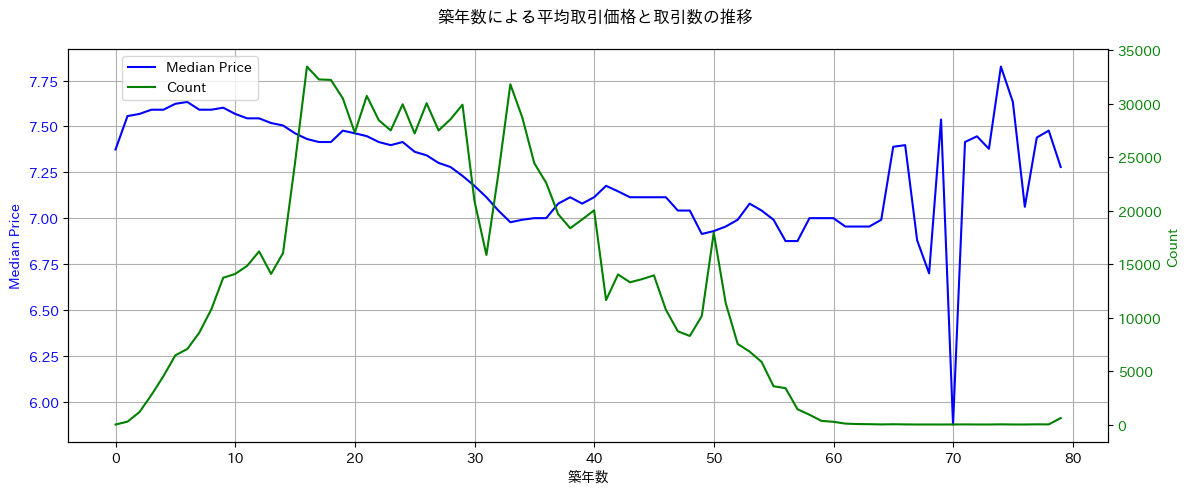

In [ ]:
import matplotlib.pyplot as plt

# データの集計
tikunen = df_train.groupby("築年数")[f"{TOTAL_PRICE_LOG}"].agg(["median", "count"])
print(tikunen)

# プロットの設定
fig, ax1 = plt.subplots(figsize=(12, 5))

# 中央値のプロット
ax1.plot(tikunen.index, tikunen["median"], color='b', label='Median Price')
ax1.set_xlabel('築年数')
ax1.set_ylabel('Median Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# countのプロット
ax2 = ax1.twinx()
ax2.plot(tikunen.index, tikunen["count"], color='g', label='Count')
ax2.set_ylabel('Count', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# タイトルと凡例
fig.suptitle('築年数による平均取引価格と取引数の推移')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.show()


          median  count
築年数                    
-0.01   7.374481      4
 0.99   7.556303    271
 1.99   7.568202   1168
 2.99   7.591065   2766
 3.99   7.591065   4515
...          ...    ...
 74.99  7.633468      7
 75.99  7.061926      6
 76.99  7.439261     22
 77.99  7.477121     16
 78.99  7.278754    607

[80 rows x 2 columns]


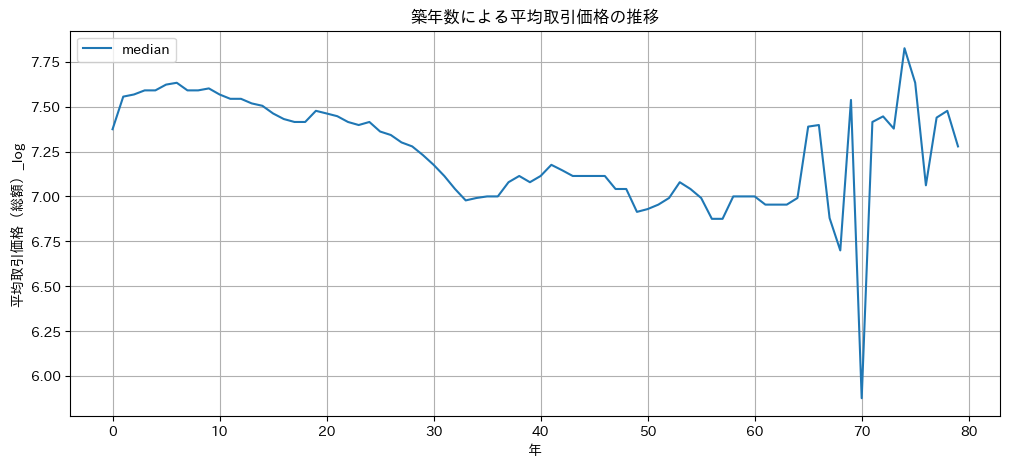

In [ ]:
tikunen=df_train.groupby("築年数")[f"{TOTAL_PRICE_LOG}"].agg(["median","count"])
print(tikunen)
#count_=df_train.groupby("築年数")[f"{TOTAL_PRICE_LOG}"].size()
#print(count_)

fig,ax=plt.subplots(figsize=(12,5))
tikunen.plot(y="median",kind='line',ax=ax)
plt.title("築年数による平均取引価格の推移")
plt.xlabel('年')
plt.ylabel('平均取引価格（総額）_log')
plt.grid(True)
plt.show()

取引時点
2005.75    7.228577
2005.99    7.246956
2006.25    7.273262
2006.50    7.181304
2006.75    7.198315
             ...   
2022.50    7.364197
2022.75    7.367152
2022.99    7.372608
2023.25    7.385044
2023.50    7.379151
Name: 取引価格（総額）_log, Length: 72, dtype: float64


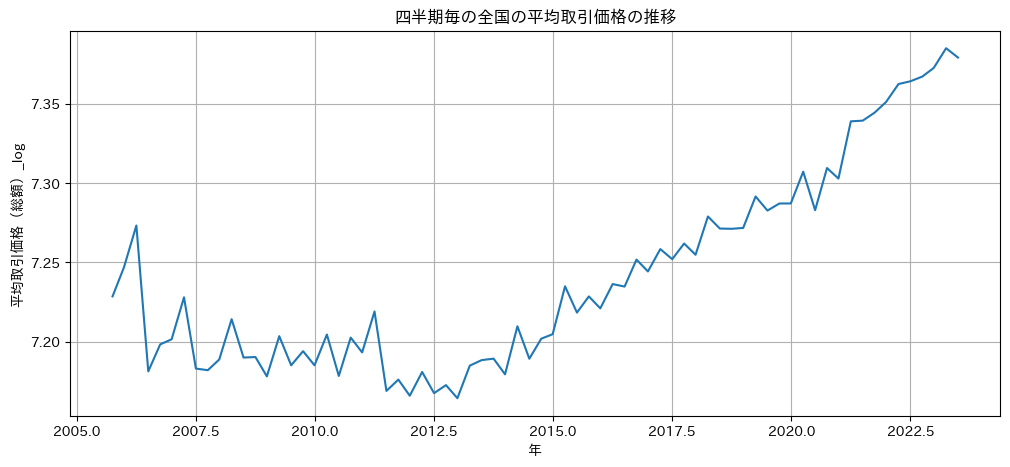

In [ ]:
average_price_per_year=df_train.groupby("取引時点")[f"{TOTAL_PRICE_LOG}"].mean()
print(average_price_per_year)
# 可視化
plt.figure(figsize=(12, 5))
average_price_per_year.plot(kind='line')
plt.title('四半期毎の全国の平均取引価格の推移')
plt.xlabel('年')
plt.ylabel('平均取引価格（総額）_log')
plt.grid(True)
plt.show()

In [ ]:
# 「取引時点」カラムをエンコードして、各ユニークな取引時点を整数に変換する処理
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)

# 時間的な特徴と地域（都道府県名）に基づいたターゲット変数の過去の平均値を計算し、それを辞書に保存する
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df[time_col].values):
    tmp_df = df[df[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TOTAL_PRICE_LOG].agg('mean').to_dict()

# te_dic[50] の出力例
# { '北海道': 3.5, '青森県': 2.8, ... }

def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df[group_col+'_te'] = df.apply(calc_te, axis=1)
df.head(2)

,dataset,ID,価格情報区分,都道府県名,市区町村名,地区名,住所不一致_Flag,住所,最寄駅：名称,最寄駅：距離（分）,...,県_市_geohash_4_駅徒歩時間平均,県_市_geohash_4_建築年平均,県_市_geohash_5_駅徒歩時間平均,県_市_geohash_5_建築年平均,県_市_geohash_6_駅徒歩時間平均,県_市_geohash_6_建築年平均,県_市_geohash_7_駅徒歩時間平均,県_市_geohash_7_建築年平均,取引時点_enc,都道府県名_te
0,train,35007328,不動産取引価格情報,山口県,下関市,秋根西町,0,山口県下関市秋根西町,新下関,2.0,...,24.497130,1997.324232,12.088968,1999.057143,4.848485,2001.266667,4.142857,2000.846154,27,7.044465
1,train,35048345,不動産取引価格情報,山口県,周南市,五月町,0,山口県周南市五月町,徳山,45.0,...,15.674336,1994.977233,15.986842,1994.156522,29.200000,1997.000000,29.200000,1997.000000,63,7.049683


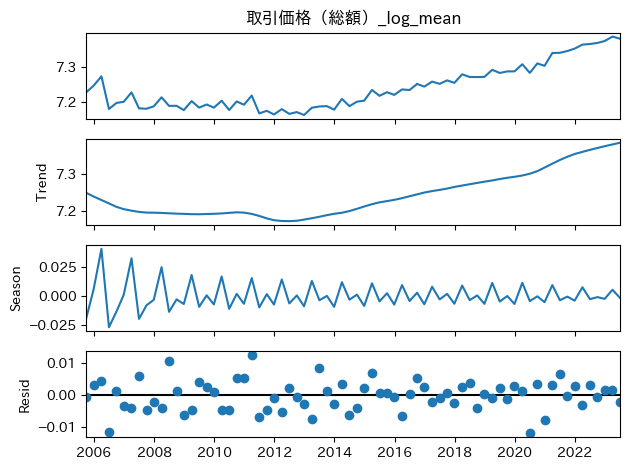

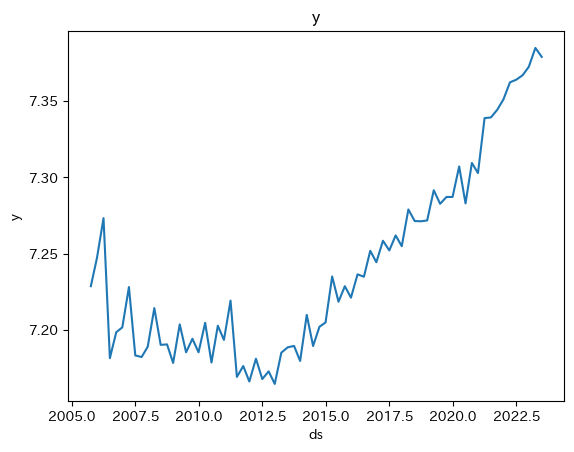

In [ ]:
df_train_tree_=df_train.copy()
df_year=df_train_tree_.groupby("取引時点")[f"{TOTAL_PRICE_LOG}"].mean().rename(f"{TOTAL_PRICE_LOG}_mean")

decomposition=STL(df_year,period=4).fit().plot()
plt.show()

graph=Multiple_Charts(df_year)
graph.year_price_test()
plt.show()

In [ ]:
print(abc)

NameError: name 'abc' is not defined

In [ ]:
tree_class=TreeExecution(df_train,y_name=PRICE_PER_AREA_LOG,cat_cols=cat_cols)
#model_lgbm=tree_class.lightgbm_simple()
fitted_models_lgbm,mae_score,oof_df=tree_class.lightgbm_l1_cv()

In [ ]:
oof_df.to_csv("/content/drive/MyDrive/yuto/project_directory/data/cv_predictions/sub_oof_lgbm_l1_cv.csv")
oof_df

In [ ]:
#model_cat=VotingModel(fitted_models_cat,cat_cols)
model_lgbm = VotingModel(fitted_models_lgbm,cat_cols)
#model_xg=VotingModel(fitted_models_xg,cat_cols)
#y_pred_cat=pd.Series(model_cat.predict_cat(df_test.drop(f"{TARGET}",axis=1)),index=df_test.index)
y_pred_lgbm=pd.Series(model_lgbm.predict_lgbm(df_test.drop(f"{PRICE_PER_AREA_LOG}",axis=1)),index=df_test.index)
#y_pred_xg=pd.Series(model_xg.predict_xg(df_test_tree.drop("取引価格（総額）_log",axis=1)),index=df_test_tree.index)


y_pred=y_pred_lgbm
# 単位面積あたりの取引価格の対数から10のべき乗を取る
price_per_area = 10**y_pred_lgbm
# その値に面積を掛けて、取引価格（総額）を計算
predicted_price_total = price_per_area * df_test["面積（㎡）"]
# 取引価格（総額）の対数を計算
y_pred= np.log10(predicted_price_total)
#y_pred=y_pred.rename(columns={"面積（㎡）":"取引価格（総額）_log"})
# Seriesの名前を変更
y_pred.name = "取引価格（総額）_log"

#y_pred=y_pred_cat
#y_pred=y_pred_lgbm
# y_predをデータフレームに変換
df_pred = pd.DataFrame(y_pred, columns=["取引価格（総額）_log"])
#print(df_pred)
#print("--------------------------------------------------------------------------------")
# インデックスをリセットし、カラム名を'ID'に変更
#df_pred.reset_index(inplace=True)
#print(df_pred)
#print("--------------------------------------------------------------------------------")
#df_pred.rename(columns={'index': 'ID'}, inplace=True)
#print(df_pred)
#print("--------------------------------------------------------------------------------")

# 結果を表示
print(df_pred)

now_str=submisson_datetime()
df_pred.to_csv("/content/drive/MyDrive/yuto/project_directory/data/intermediate_results/one_model_predictions/sub_test_lgbm_l1_cv.csv")


In [ ]:
df_sub=pd.read_csv("/content/drive/MyDrive/yuto/project_directory/data/final_predictions/test_lgbm_cv20240908_111634.csv")
print(df_sub)

In [ ]:
def ML_Record(df, model, cv_score, now_str, model_name):
    # 例として、取得したカラム名のリスト
    columns = df.columns.tolist()

    # モデルがアンサンブルか単一のモデルかをチェック
    if hasattr(model, 'estimators'):
        # 各estimatorのパラメータを取得し、全て同じかチェック
        params_list = [estimator.get_params() for estimator in model.estimators]
        # 最初のモデルのパラメータを基準に比較
        base_params = params_list[0]
        all_same = all(params == base_params for params in params_list)

        if all_same:
            print("All estimators have the same parameters.")
        else:
            print("Not all estimators have the same parameters.")

        # 各estimatorのパラメータを表示
        for i, params in enumerate(params_list):
            print(f"Estimator {i} parameters: {params}")
    else:
        # 単一のモデルの場合
        base_params = model.get_params()
        print("Single model parameters:", base_params)

    # ピリオドをアンダースコアに置き換えたファイル名
    cv_score_str = str(cv_score).replace(".", "_")

    # モデルの保存
    joblib.dump(model, f"/content/drive/MyDrive/yuto/project_directory/models/sub_model_{model_name}_{cv_score_str}.pkl")

    # jsonファイル作成
    data_to_save = {
        'columns': columns,
        f'{model_name}_params': base_params,
        'cv_score': cv_score,
        'lb_score': None
    }
    filename = f"/content/drive/MyDrive/yuto/project_directory/data/model_params/sub_model_{model_name}_{cv_score_str}.json"
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data_to_save, f, ensure_ascii=False, indent=4)

In [ ]:
ML_Record(df_train, model_lgbm, mae_score, now_str, model_name="lgbm_l1_cv")

In [ ]:
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from ipywidgets import interact, Select, Dropdown
from IPython.display import display

def geohash_to_polygon(gh):
    #print(gh)
    if pd.isna(gh):
        return None
    
    bounds = geohash.bounds(gh)
    return Polygon([
        (bounds[0][1], bounds[0][0]),
        (bounds[0][1], bounds[1][0]),
        (bounds[1][1], bounds[1][0]),
        (bounds[1][1], bounds[0][0]),
        (bounds[0][1], bounds[0][0])
    ])

# データフレームを読み込み、必要な列をグループ化してジオハッシュの境界ボックスを計算
df = df_train.groupby(["取引時点", "geohash_2", "geohash_3", "geohash_4", "geohash_5", "geohash_6", "geohash_7"])[f"{TOTAL_PRICE_LOG}"].mean().reset_index()

# カウント集約を追加
df_count = df_train.groupby(["取引時点", "geohash_2", "geohash_3", "geohash_4", "geohash_5", "geohash_6", "geohash_7"]).size().reset_index(name='count')

# 各ジオハッシュレベルでのデータを個別にフィルタリング
def process_geohash_level(level):
    df_mean = df.groupby(["取引時点", level])[f"{TOTAL_PRICE_LOG}"].mean().reset_index()
    df_mean['geometry'] = [geohash_to_polygon(gh) for gh in df_mean[level]]
    
    df_count_level = df_count.groupby(["取引時点", level])['count'].sum().reset_index()
    df_merged = pd.merge(df_mean, df_count_level, on=["取引時点", level])
    
    gdf = gpd.GeoDataFrame(df_merged, geometry='geometry')
    gdf.set_crs(epsg=4326, inplace=True)
    
    return gdf

gdf_geohash_2 = process_geohash_level("geohash_2")
gdf_geohash_3 = process_geohash_level("geohash_3")
print(gdf_geohash_3)
gdf_geohash_4 = process_geohash_level("geohash_4")
gdf_geohash_5 = process_geohash_level("geohash_5")
gdf_geohash_6 = process_geohash_level("geohash_6")
gdf_geohash_7 = process_geohash_level("geohash_7")

# 全てのジオハッシュレベルのデータフレームを連結
gdf_all = pd.concat([gdf_geohash_2, gdf_geohash_3, gdf_geohash_4, gdf_geohash_5, gdf_geohash_6, gdf_geohash_7])
unique_dates = gdf_all['取引時点'].unique()
unique_geohash_levels = ['geohash_2', 'geohash_3', 'geohash_4', 'geohash_5', 'geohash_6', 'geohash_7']
date_selector = Select(options=unique_dates, description='取引時点:')
geohash_selector = Dropdown(options=unique_geohash_levels, description='Geohash Level:')

# 地図を更新する関数を定義
def update_map(selected_date, selected_geohash):
    m = folium.Map(location=[35.0, 135.0], zoom_start=5)
    if selected_geohash == 'geohash_2':
        selected_gdf = gdf_geohash_2[gdf_geohash_2['取引時点'] == selected_date]
    elif selected_geohash == 'geohash_3':
        selected_gdf = gdf_geohash_3[gdf_geohash_3['取引時点'] == selected_date]
    elif selected_geohash == 'geohash_4':
        selected_gdf = gdf_geohash_4[gdf_geohash_4['取引時点'] == selected_date]
    elif selected_geohash == 'geohash_5':
        selected_gdf = gdf_geohash_5[gdf_geohash_5['取引時点'] == selected_date]
    elif selected_geohash == 'geohash_6':
        selected_gdf = gdf_geohash_6[gdf_geohash_6['取引時点'] == selected_date]
    elif selected_geohash == 'geohash_7':
        selected_gdf = gdf_geohash_7[gdf_geohash_7['取引時点'] == selected_date]
    
    # Choropleth layer for the average price
    folium.Choropleth(
        geo_data=selected_gdf,
        name='choropleth',
        data=selected_gdf,
        columns=[selected_geohash, f"{TOTAL_PRICE_LOG}"],
        key_on=f'feature.properties.{selected_geohash}',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='平均価格'
    ).add_to(m)

    # Add a feature group for the counts
    counts_column = f"{selected_geohash}_count"
    selected_gdf[counts_column] = selected_gdf.groupby(selected_geohash)[selected_geohash].transform('count')

    folium.GeoJson(
        selected_gdf,
        name='counts',
        style_function=lambda x: {
            'fillColor': '#ffaf00',
            'color': '#ffaf00',
            'weight': 1,
            'dashArray': '5, 5'
        },
        tooltip=folium.GeoJsonTooltip(fields=[counts_column], aliases=['Count:'])
    ).add_to(m)

    folium.LayerControl().add_to(m)

    display(m)

# インタラクティブに地図を更新する
interact(update_map, selected_date=date_selector, selected_geohash=geohash_selector)

In [ ]:
#個別でデータ作成している

import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from ipywidgets import interact, Select, Dropdown
from IPython.display import display

def geohash_to_polygon(gh):
    #print(gh)
    if pd.isna(gh):
        return None
    
    bounds = geohash.bounds(gh)
    return Polygon([
        (bounds[0][1], bounds[0][0]),
        (bounds[0][1], bounds[1][0]),
        (bounds[1][1], bounds[1][0]),
        (bounds[1][1], bounds[0][0]),
        (bounds[0][1], bounds[0][0])
    ])


# データフレームを読み込み、必要な列をグループ化してジオハッシュの境界ボックスを計算
df = df_train.groupby(["取引時点", "geohash_2", "geohash_3", "geohash_4", "geohash_5", "geohash_6", "geohash_7"])[f"{TOTAL_PRICE_LOG}"].mean().reset_index()

# 各ジオハッシュレベルでのデータを個別にフィルタリング
df_geohash_2 = df.groupby(["取引時点", "geohash_2"])[f"{TOTAL_PRICE_LOG}"].mean().reset_index()
df_geohash_2['geometry'] = [geohash_to_polygon(geohash) for geohash in tqdm(df_geohash_2['geohash_2'],desc=f"Calculating geohash polygons level:2")]
gdf_geohash_2 = gpd.GeoDataFrame(df_geohash_2, geometry='geometry')
gdf_geohash_2.set_crs(epsg=4326, inplace=True)

df_geohash_3 = df.groupby(["取引時点", "geohash_3"])[f"{TOTAL_PRICE_LOG}"].mean().reset_index()
df_geohash_3['geometry'] = [geohash_to_polygon(geohash) for geohash in tqdm(df_geohash_3['geohash_3'],desc=f"Calculating geohash polygons level:3")]
gdf_geohash_3 = gpd.GeoDataFrame(df_geohash_3, geometry='geometry')
gdf_geohash_3.set_crs(epsg=4326, inplace=True)

df_geohash_4 = df.groupby(["取引時点", "geohash_4"])[f"{TOTAL_PRICE_LOG}"].mean().reset_index()
df_geohash_4['geometry'] = [geohash_to_polygon(geohash) for geohash in tqdm(df_geohash_4['geohash_4'],desc=f"Calculating geohash polygons level:4")]
gdf_geohash_4 = gpd.GeoDataFrame(df_geohash_4, geometry='geometry')
gdf_geohash_4.set_crs(epsg=4326, inplace=True)

df_geohash_5 = df.groupby(["取引時点", "geohash_5"])[f"{TOTAL_PRICE_LOG}"].mean().reset_index()
df_geohash_5['geometry'] = [geohash_to_polygon(geohash) for geohash in tqdm(df_geohash_5['geohash_5'],desc=f"Calculating geohash polygons level:5")]
gdf_geohash_5 = gpd.GeoDataFrame(df_geohash_5, geometry='geometry')
gdf_geohash_5.set_crs(epsg=4326, inplace=True)

df_geohash_6 = df.groupby(["取引時点", "geohash_6"])[f"{TOTAL_PRICE_LOG}"].mean().reset_index()
df_geohash_6['geometry'] = [geohash_to_polygon(geohash) for geohash in tqdm(df_geohash_6['geohash_6'],desc=f"Calculating geohash polygons level:6")]
gdf_geohash_6 = gpd.GeoDataFrame(df_geohash_6, geometry='geometry')
gdf_geohash_6.set_crs(epsg=4326, inplace=True)

df_geohash_7 = df.groupby(["取引時点", "geohash_7"])[f"{TOTAL_PRICE_LOG}"].mean().reset_index()
df_geohash_7['geometry'] = [geohash_to_polygon(geohash) for geohash in tqdm(df_geohash_7['geohash_7'],desc=f"Calculating geohash polygons level:7")]
gdf_geohash_7 = gpd.GeoDataFrame(df_geohash_7, geometry='geometry')
gdf_geohash_7.set_crs(epsg=4326, inplace=True)

# 全てのジオハッシュレベルのデータフレームを連結
gdf_all = pd.concat([gdf_geohash_2, gdf_geohash_3, gdf_geohash_4, gdf_geohash_5, gdf_geohash_6, gdf_geohash_7])
unique_dates = gdf_all['取引時点'].unique()
unique_geohash_levels = ['geohash_2', 'geohash_3', 'geohash_4', 'geohash_5', 'geohash_6', 'geohash_7']
date_selector = Select(options=unique_dates, description='取引時点:')
geohash_selector = Dropdown(options=unique_geohash_levels, description='Geohash Level:')

# 地図を更新する関数を定義
def update_map(selected_date, selected_geohash):
    m = folium.Map(location=[35.0, 135.0], zoom_start=5)
    if selected_geohash == 'geohash_2':
        selected_gdf = gdf_geohash_2[gdf_geohash_2['取引時点'] == selected_date]
    elif selected_geohash == 'geohash_3':
        selected_gdf = gdf_geohash_3[gdf_geohash_3['取引時点'] == selected_date]
    elif selected_geohash == 'geohash_4':
        selected_gdf = gdf_geohash_4[gdf_geohash_4['取引時点'] == selected_date]
    elif selected_geohash == 'geohash_5':
        selected_gdf = gdf_geohash_5[gdf_geohash_5['取引時点'] == selected_date]
    elif selected_geohash == 'geohash_6':
        selected_gdf = gdf_geohash_6[gdf_geohash_6['取引時点'] == selected_date]
    elif selected_geohash == 'geohash_7':
        selected_gdf = gdf_geohash_7[gdf_geohash_7['取引時点'] == selected_date]

    folium.Choropleth(
        geo_data=selected_gdf,
        name='choropleth',
        data=selected_gdf,
        columns=[selected_geohash, f"{TOTAL_PRICE_LOG}"],
        key_on=f'feature.properties.{selected_geohash}',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='平均価格'
    ).add_to(m)

    folium.LayerControl().add_to(m)

    display(m)

interact(update_map, selected_date=date_selector, selected_geohash=geohash_selector)